In [1]:
import os, sys, math
import glob
import cv2
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
# import plotly.express as px
# Custom modules
sys.path.append('../../NanoscoPy/')
from nanoscopy import spectrum
from nanoscopy.utilities import dialog_askfilename, dialog_askdirectory 

In [2]:
dir = dialog_askdirectory()

In [3]:
# read data in dir
files = spectrum.io.read(dir)

In [4]:
for file in files:
    file.metadata = file.data[:9]
    file.data = file.data.drop(list(range(11)))
    file.data = file.data.drop('Unnamed: 2', axis=1)
    file.data.columns = ['Frequency (Hz)','Current PSD (fA/sqrt(Hz))']
    file.data.reset_index(drop=True, inplace=True)
    file.data['Frequency (Hz)'] = pd.to_numeric(file.data['Frequency (Hz)'])
    file.data['Current PSD (fA/sqrt(Hz))'] = pd.to_numeric(file.data['Current PSD (fA/sqrt(Hz))']) * 10**15

<AxesSubplot:xlabel='Frequency (Hz)'>

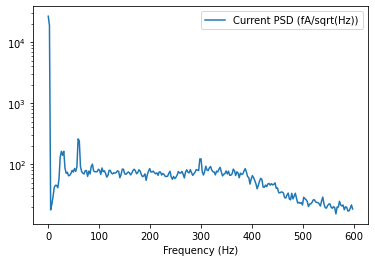

In [5]:
files[0].data.plot(x='Frequency (Hz)', y='Current PSD (fA/sqrt(Hz))', logy=True)

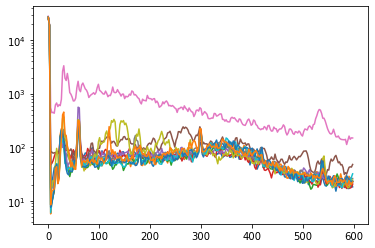

In [8]:
for file in files:
    x = file.data['Frequency (Hz)']
    y = file.data['Current PSD (fA/sqrt(Hz))']
    plt.plot(x, y)

plt.yscale('log')
# plt.xlim(50,70)
# plt.ylim(0,2)

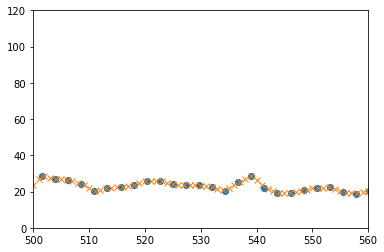

In [22]:
from scipy import interpolate
x = np.arange(0, 10)
x = files[6].data['Frequency (Hz)']
y = np.exp(-x/3.0)
y = files[0].data['Current PSD (fA/sqrt(Hz))']
f = interpolate.interp1d(x, y)
xnew = np.arange(0, 9, 0.1)
xnew = np.arange(0,x.iat[-1],1)
ynew = f(xnew)   # use interpolation function returned by `interp1d`
plt.plot(x, y, 'o', xnew, ynew, 'x')
plt.xlim(500,560)
plt.ylim(0,120)
# plt.yscale('log')
plt.show()

In [58]:
model_psd = [
    {'name':'mechanical',
    'type': 'Gaussian',
    'center': {'value':30},
    'height': {'value':160},
    'FWHM': {'value':10} 
    },
    {'name':'boardband2nd',
    'type': 'Gaussian',
    'center': {'value':50},
    'height': {'value':80},
    'FWHM': {'value':60} 
    },
    {'name':'boardband3rd',
    'type': 'Gaussian',
    'center': {'value':360},
    'height': {'value':75},
    'FWHM': {'value':120} 
    },
    {'name':'electronic',
    'type': 'Gaussian',
    'center': {'value':60},
    'height': {'value':250},
    'FWHM': {'value':5} 
    },
    {'name':'electronic2nd',
    'type': 'Gaussian',
    'center': {'value':120},
    'height': {'value':80},
    'FWHM': {'value':5} 
    },
    {'name':'electronic3nd',
    'type': 'Gaussian',
    'center': {'value':180},
    'height': {'value':80},
    'FWHM': {'value':5} 
    },
    {'name':'electronic4nd',
    'type': 'Gaussian',
    'center': {'value':240},
    'height': {'value':80},
    'FWHM': {'value':5} 
    },
    {'name':'electronic5nd',
    'type': 'Gaussian',
    'center': {'value':300},
    'height': {'value':80},
    'FWHM': {'value':5} 
    },
    {'name':'electronic6nd',
    'type': 'Gaussian',
    'center': {'value':360},
    'height': {'value':80},
    'FWHM': {'value':5} 
    },
    {'name':'electronic7nd',
    'type': 'Gaussian',
    'center': {'value':420},
    'height': {'value':80},
    'FWHM': {'value':5} 
    },
    {'name':'electronic9th',
    'type': 'Gaussian',
    'center': {'value':540},
    'height': {'value':30},
    'FWHM': {'value':5} 
    },
    ]

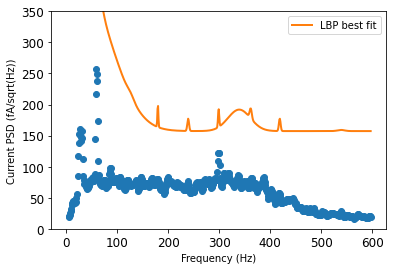

In [59]:
# for file in [files[0]]:
file = files[0]
x = file.data['Frequency (Hz)']
y = file.data['Current PSD (fA/sqrt(Hz))']
f = interpolate.interp1d(x, y)
xnew = np.arange(0, x.iat[-1], 1)
ynew = f(xnew)   # use interpolation function returned by `interp1d`
# plt.plot(x, y, 'o', xnew, ynew, '-')
data = np.array((xnew,ynew)).T
# data = file.data.to_numpy()
spec = spectrum.peak_fit.PeakFit(data)
spec.make_composite_model(model_psd, min=1e-13)
spec.fit_spectrum()
plt.plot(spec.data_x, spec.data_y, 'o')
plt.plot(spec.data_x, spec.results.best_fit, label='best fit', linewidth=2.0)
# pf = spec.results.plot()
# plt.yscale('log')
plt.ylim(0,350)
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.legend(loc='best')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Current PSD (fA/sqrt(Hz))')
plt.show()

In [ ]:
psd = pd.concat([file.data for file in files], axis=1)

In [ ]:
# Locate the peaks in the data and determine parameter values.
peak_indices , peak_properties = spec.locate_peaks(filter_window_length=9,filter_polyorder=1,finder_prominence=5,wlen=300, width=150)

# Generate a plot to visualize the peak detection results
plt.plot(spec.data_x,spec.data_y,label='Raw Data')
plt.plot(spec.data_x[peak_indices], spec.data_y[peak_indices],'*',label='Detected Peak Locations')
plt.legend()

new_model_parameters = spec.generate_model_parameters(peak_indices,peak_properties)

spec.make_composite_model(new_model_parameters)